# Reddit Mental Health Data Using Spark NLP

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master('local[*]').appName('spark_nlp').config("spark.driver.memory","8G").getOrCreate()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
343,application_1681238170162_0343,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Load the data

First, we load the data.

In [2]:
reddit = spark.read.options(delimiter=',', header=True, inferSchema=True, multiLine=True, escape='\"')\
        .csv("s3a://msbx5420-spr23/project_group3/mental_disorders_reddit.csv")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
reddit.printSchema()

root
 |-- title: string (nullable = true)
 |-- selftext: string (nullable = true)
 |-- created_utc: integer (nullable = true)
 |-- over_18: boolean (nullable = true)
 |-- subreddit: string (nullable = true)



In [4]:
reddit.show(30)

+--------------------+--------------------+-----------+-------+---------+
|               title|            selftext|created_utc|over_18|subreddit|
+--------------------+--------------------+-----------+-------+---------+
|Life is so pointl...|Does anyone else ...| 1650356960|  false|      BPD|
|          Cold rage?|Hello fellow frie...| 1650356660|  false|      BPD|
|I don’t know who ...|My [F20] bf [M20]...| 1650355379|  false|      BPD|
|HELP! Opinions! A...|Okay, I’m about t...| 1650353430|  false|      BPD|
|                help|           [removed]| 1650350907|  false|      BPD|
|My ex got diagnos...|Without going int...| 1650350635|  false|      BPD|
|Is misdiagnosis o...|(Reposting here o...| 1650349446|  false|      BPD|
|I have trouble id...|I grew up mostly ...| 1650349125|  false|      BPD|
|     Needing advice…|I posted on this ...| 1650349094|  false|      BPD|
|      Do I have BPD?|           [removed]| 1650349072|   true|      BPD|
|How do you deal w...|If they were to 

In [5]:
from pyspark.sql.functions import from_unixtime, date_format

reddit = reddit.withColumn("date", from_unixtime("created_utc").cast("date")) \
                         .withColumn("date_string", date_format("date", "MM-dd-yyyy")) \
                         .drop("date", "created_utc")

In [6]:
reddit.show(30)

+--------------------+--------------------+-------+---------+-----------+
|               title|            selftext|over_18|subreddit|date_string|
+--------------------+--------------------+-------+---------+-----------+
|Life is so pointl...|Does anyone else ...|  false|      BPD| 04-19-2022|
|          Cold rage?|Hello fellow frie...|  false|      BPD| 04-19-2022|
|I don’t know who ...|My [F20] bf [M20]...|  false|      BPD| 04-19-2022|
|HELP! Opinions! A...|Okay, I’m about t...|  false|      BPD| 04-19-2022|
|                help|           [removed]|  false|      BPD| 04-19-2022|
|My ex got diagnos...|Without going int...|  false|      BPD| 04-19-2022|
|Is misdiagnosis o...|(Reposting here o...|  false|      BPD| 04-19-2022|
|I have trouble id...|I grew up mostly ...|  false|      BPD| 04-19-2022|
|     Needing advice…|I posted on this ...|  false|      BPD| 04-19-2022|
|      Do I have BPD?|           [removed]|   true|      BPD| 04-19-2022|
|How do you deal w...|If they were to 

In [7]:
from pyspark.sql.functions import min, max

In [8]:
# Get the oldest and newest dates from the "created_utc" column
oldest_date = reddit.select(min("date_string")).first()[0]
newest_date = reddit.select(max("date_string")).first()[0]

print("Oldest date:", oldest_date)
print("Newest date:", newest_date)

Oldest date: 01-01-2014
Newest date: 12-31-2021


In [9]:
from pyspark.sql.functions import regexp_replace

In [10]:
reddit = reddit.withColumn("subreddit", regexp_replace(reddit["subreddit"], "bipolar", "BIPOLAR"))

In [11]:
reddit = reddit.repartition(30)

In [12]:
import time
start_time = time.time()
print(reddit.count())
print("--- %s seconds ---" % (time.time() - start_time))

701787
--- 139.29344058036804 seconds ---


In [13]:
pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 1.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 769.6/769.6 kB 1.9 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [14]:
pip install textblob

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.8/636.8 kB 251.6 kB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [15]:
import nltk
import textblob
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
import pyspark.sql.functions as F
from pyspark.sql.functions import col
from pyspark.sql.types import StringType
from pyspark.sql import SparkSession
from nltk.corpus import stopwords
from textblob import TextBlob
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, udf
import re

In [17]:
# handle null values in clean_freetext column
def replace_null(x):
    if x is None:
        return ''
    else:
        return x

In [18]:
replace_null_udf = udf(replace_null, StringType())
reddit = reddit.withColumn('selftext', replace_null_udf(col('selftext')))

In [19]:
# remove stopwords from freetext column
stop_words = set(stopwords.words('english'))
filter_spam = F.udf(lambda x: " ".join([word for word in x.lower().split() if word not in stop_words]), StringType())
reddit = reddit.withColumn('clean_selftext', filter_spam(col('selftext')))

In [20]:
# remove stopwords from Title column
stop_words = set(stopwords.words('english'))
filter_spam = F.udf(lambda x: " ".join([word for word in x.lower().split() if word not in stop_words]), StringType())
reddit = reddit.withColumn('clean_title', filter_spam(col('title')))

In [21]:
reddit.show(10)

+--------------------+--------------------+-------+-------------+-----------+--------------------+--------------------+
|               title|            selftext|over_18|    subreddit|date_string|      clean_selftext|         clean_title|
+--------------------+--------------------+-------+-------------+-----------+--------------------+--------------------+
|He’s not coming b...|I’m in legal trou...|  false|          BPD| 11-04-2021|i’m legal trouble...|he’s coming back ...|
|Does anyone else ...|My fp is my bf an...|  false|          BPD| 06-18-2021|fp bf he’s amazin...|anyone else try a...|
|Do you also demon...|In my opinion, wh...|  false|          BPD| 06-29-2018|opinion, love man...|also demonize per...|
|Idk what's wrong ...|Recently I've wen...|  false|   depression| 06-24-2022|recently i've wen...|idk what's wrong me.|
|             Analagy|\nI came up with ...|  false|   depression| 05-02-2022|came analogy make...|             analagy|
|my gf is suddenly...|i don't even use .

### Word Counts of the 'SelfText' Column

In [22]:
import pyspark.sql.functions as fn
import time

start_time = time.time()

#Split the lines into words
words = reddit.select(fn.explode(fn.split(fn.concat_ws(" ", reddit.clean_selftext), ' ')).alias('word'))

#Generate word count
word_counts = words.groupBy('word').count()

# Sort by count in descending order and take the top 10
top10 = word_counts.orderBy('count', ascending=False).limit(10)

top10.show()

print("--- %s seconds ---" % (time.time() - start_time))

+------+------+
|  word| count|
+------+------+
|  like|720840|
|  feel|578344|
|   i'm|521733|
|   i’m|471377|
|  know|404265|
|   get|372578|
|  want|346615|
|really|313670|
|  even|308379|
|people|234724|
+------+------+

--- 81.00692296028137 seconds ---


### Word Counts of the 'Title' Column

In [23]:
from pyspark.sql import functions as fn
reddit = reddit.filter(fn.col("title").isNotNull())

In [24]:
reddit.count()

701741

In [25]:
import pyspark.sql.functions as fn
import time

start_time = time.time()

#Split the lines into words
words2 = reddit.select(fn.explode(fn.split(fn.concat_ws(" ", reddit.clean_title), ' ')).alias('word2'))

#Generate word count
word_counts2 = words2.groupBy('word2').count()

# Sort by count in descending order and take the top 10
top10_2 = word_counts2.orderBy('count', ascending=False).limit(10)

top10_2.show()

print("--- %s seconds ---" % (time.time() - start_time))

+-------+-----+
|  word2|count|
+-------+-----+
|   feel|46177|
|anxiety|45834|
|   like|37183|
| anyone|35617|
|    i'm|32209|
|    i’m|31356|
|    bpd|27480|
|    get|25525|
|   help|24560|
|   need|21865|
+-------+-----+

--- 55.948392391204834 seconds ---


### Sentiment Analysis of 'Self Text' grouped by Subreddit

In [26]:
!pip install pyspark
!pip install nltk
!pip install textblob

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 1.5 MB/s eta 0:00:00a 0:00:01


In [27]:
# calculate sentiment score of clean_freetext column
get_sentiment = F.udf(lambda x: TextBlob(x).sentiment.polarity, StringType())
reddit = reddit.withColumn('sentiment', get_sentiment(col('clean_selftext')))

In [28]:
reddit.printSchema()

root
 |-- title: string (nullable = true)
 |-- selftext: string (nullable = true)
 |-- over_18: boolean (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- date_string: string (nullable = true)
 |-- clean_selftext: string (nullable = true)
 |-- clean_title: string (nullable = true)
 |-- sentiment: string (nullable = true)



In [29]:
# calculate sentiment score and label of clean_freetext column
def get_sentiment(x):
    if x:
        score = TextBlob(x).sentiment.polarity
        if score > 0:
            return 'Positive'
        elif score < 0:
            return 'Negative'
        else:
            return 'Neutral'
    else:
        return None

In [30]:
get_sentiment_udf = udf(get_sentiment, StringType())
reddit = reddit.withColumn('sentiment_category', get_sentiment_udf(col('clean_selftext')))

In [31]:
reddit.show(10)

+--------------------+--------------------+-------+-------------+-----------+--------------------+--------------------+--------------------+------------------+
|               title|            selftext|over_18|    subreddit|date_string|      clean_selftext|         clean_title|           sentiment|sentiment_category|
+--------------------+--------------------+-------+-------------+-----------+--------------------+--------------------+--------------------+------------------+
|He’s not coming b...|I’m in legal trou...|  false|          BPD| 11-04-2021|i’m legal trouble...|he’s coming back ...| 0.15952380952380954|          Positive|
|Does anyone else ...|My fp is my bf an...|  false|          BPD| 06-18-2021|fp bf he’s amazin...|anyone else try a...| 0.10833333333333332|          Positive|
|Do you also demon...|In my opinion, wh...|  false|          BPD| 06-29-2018|opinion, love man...|also demonize per...| 0.04516369047619047|          Positive|
|Idk what's wrong ...|Recently I've wen.

In [57]:
from pyspark.sql.functions import col
reddit_positive = reddit.filter(col("sentiment_category") == "Positive")
reddit_negative = reddit.filter(col("sentiment_category") == "Negative")

In [58]:
reddit_positive.show(5)

+--------------------+--------------------+-------+----------+-----------+--------------------+--------------------+-------------------+------------------+----+
|               title|            selftext|over_18| subreddit|date_string|      clean_selftext|         clean_title|          sentiment|sentiment_category|date|
+--------------------+--------------------+-------+----------+-----------+--------------------+--------------------+-------------------+------------------+----+
|feeling guilty ab...|I’ve had depressi...|  false|depression| 07-30-2022|i’ve depression l...|feeling guilty de...|0.08504464285714285|          Positive|null|
|I stood up for my...|I have been going...|  false|       BPD| 06-07-2021|going break letti...|stood let feels c...| 0.3842857142857143|          Positive|null|
|Heartbroken, suic...|This is going to ...|  false|       BPD| 09-27-2020|going sound silly...|heartbroken, suic...|0.17910509031198685|          Positive|null|
|please. any help....|im  gonna tr

In [59]:
reddit_negative.show(5)

+--------------------+--------------------+-------+-------------+-----------+--------------------+--------------------+--------------------+------------------+----+
|               title|            selftext|over_18|    subreddit|date_string|      clean_selftext|         clean_title|           sentiment|sentiment_category|date|
+--------------------+--------------------+-------+-------------+-----------+--------------------+--------------------+--------------------+------------------+----+
|How to handle rom...|Its really painfu...|  false|      Anxiety| 07-25-2021|really painful fe...|handle romantic r...|-0.20595238095238091|          Negative|null|
|It’s going be a v...|It’s going to be ...|  false|   depression| 07-23-2022|it’s going one ho...|it’s going long l...| -0.2145833333333333|          Negative|null|
|Eye related side-...|Anyone else get t...|  false|schizophrenia| 03-28-2022|anyone else get h...|eye related side-...|-0.03272727272727274|          Negative|null|
|For me de

In [47]:
from pyspark.sql.functions import count
import pyspark.sql.functions as F
from pyspark.sql.functions import year, month, concat_ws
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

In [39]:
# Group by sentiment_category over date_string
sentiment_by_date = reddit.groupBy("sentiment_category", "date_string").agg(count("*").alias("count"))

# Order by date
sentiment_by_date = sentiment_by_date.orderBy("date_string")

In [40]:
sentiment_by_date.show()

+------------------+-----------+-----+
|sentiment_category|date_string|count|
+------------------+-----------+-----+
|          Positive| 01-01-2014|    2|
|          Negative| 01-01-2014|    3|
|          Positive| 01-01-2015|    5|
|           Neutral| 01-01-2015|    1|
|          Negative| 01-01-2015|    2|
|          Positive| 01-01-2016|    4|
|           Neutral| 01-01-2016|    7|
|          Negative| 01-01-2016|    2|
|              null| 01-01-2016|    2|
|          Positive| 01-01-2017|   15|
|              null| 01-01-2017|    5|
|           Neutral| 01-01-2017|    6|
|          Negative| 01-01-2017|    6|
|              null| 01-01-2018|    8|
|          Negative| 01-01-2018|   19|
|           Neutral| 01-01-2018|    8|
|          Positive| 01-01-2018|   16|
|          Negative| 01-01-2019|   26|
|           Neutral| 01-01-2019|    2|
|              null| 01-01-2019|    9|
+------------------+-----------+-----+
only showing top 20 rows



/tmp/ipykernel_119/1093217334.py:6: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for key, grp in pandas_df.groupby(["sentiment_category"]):


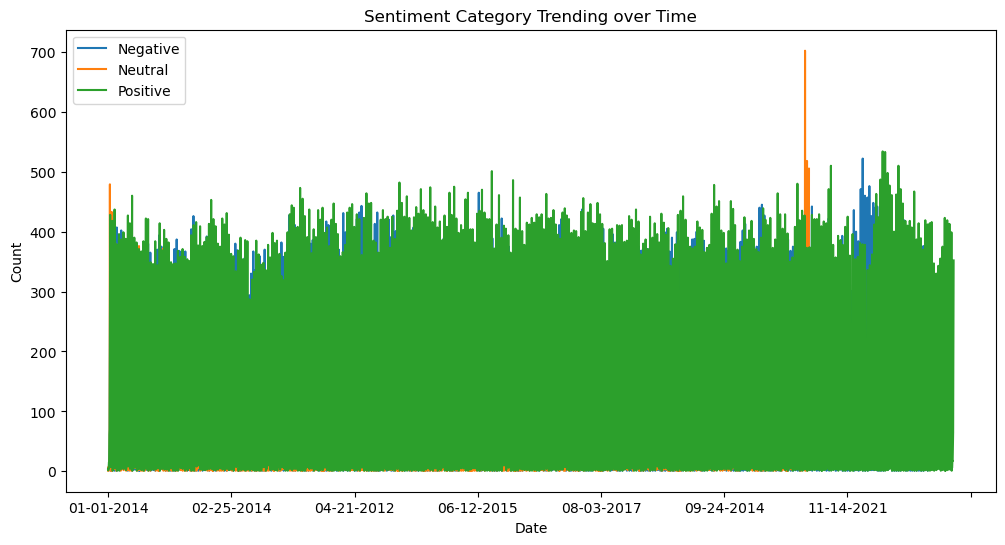

In [54]:
# Convert DataFrame to Pandas for plotting
pandas_df = sentiment_by_date.toPandas()

# Plot data
fig, ax = plt.subplots(figsize=(12, 6))
for key, grp in pandas_df.groupby(["sentiment_category"]):
    ax = grp.plot(ax=ax, kind='line', x='date_string', y='count', label=key)
ax.set_xlabel("Date")
ax.set_ylabel("Count")
ax.set_title("Sentiment Category Trending over Time")
ax.legend(loc='upper left')
plt.show()

In [55]:
# group by channel and sentiment and count the number of records
sentiment_count = reddit.groupBy('subreddit', 'sentiment_category').count()

# pivot the sentiment column and fill null values with 0
sentiment_count = sentiment_count.groupBy('subreddit').pivot('sentiment_category', ['Negative', 'Neutral', 'Positive']).sum('count').fillna(0)

In [31]:
sentiment_count.show()

+-------------+--------+-------+--------+
|    subreddit|Negative|Neutral|Positive|
+-------------+--------+-------+--------+
|      BIPOLAR|   13320|  13789|   19546|
|          BPD|   88536|  33959|  110574|
|   depression|   57201|  41203|   58302|
|mentalillness|   17627|   8605|   18009|
|      Anxiety|   77670|  12857|   76491|
|schizophrenia|    4122|  10227|    5926|
+-------------+--------+-------+--------+



### Topic Extraction

In [57]:
from pyspark.sql.functions import explode, split, regexp_extract, col, lower

In [58]:
# Replace special characters and punctuation with spaces and change text to lowercase
reddit = reddit.withColumn("selftext_cleaned", lower(regexp_replace(col("selftext"), "[^a-zA-Z0-9\\s.,?]+", " ")))

In [59]:
from pyspark.sql.functions import regexp_replace

# Define a regular expression pattern to remove unwanted characters
pattern = "[\n/]|r/"

# Apply the regular expression to the "title" and "selftext" columns and replace the matches with an empty string
reddit = reddit.withColumn("title_cleaned", regexp_replace(col("title"), pattern, ""))
reddit = reddit.withColumn("selftext_cleaned", regexp_replace(col("selftext_cleaned"), pattern, ""))

In [60]:
from pyspark.sql.functions import regexp_replace

# Replace the ")( " characters with a comma
reddit = reddit.withColumn("selftext_cleaned", regexp_replace(col("selftext_cleaned"), "\)\(\/)s", ","))

# Remove any remaining ")" and "(" characters
reddit = reddit.withColumn("selftext_cleaned", regexp_replace(col("selftext_cleaned"), "[\(\)]", ""))

In [61]:
regexp_replace(col("selftext_cleaned"), "[.,!?]", "")

Column<'regexp_replace(selftext_cleaned, [.,!?], , 1)'>

In [65]:
from pyspark.sql.functions import lower, regexp_replace, col, udf
from pyspark.sql.types import StringType

# Define a function to remove punctuation marks from the cleaned text
def remove_punctuation(text):
    return text.translate(str.maketrans('',"" '',... '.,!?'))

# Define a UDF to apply the remove_punctuation function to each row in the DataFrame
remove_punctuation_udf = udf(remove_punctuation, StringType())

# Clean the "selftext" column and remove punctuation marks
reddit = reddit.withColumn("selftext_cleaned", lower(regexp_replace(col("selftext"), "[^a-zA-Z0-9\\s]+\nr/", " ")))
reddit = reddit.withColumn("selftext_cleaned", remove_punctuation_udf(col("selftext_cleaned")))

In [66]:
# Define a regular expression pattern to match topics
pattern = r"(?i)\b(anxiety|depression|bipolar|schizophrenia|PTSD|OCD|ADHD|autism|panic|stress)\b"

In [67]:
# Split the selftext column by whitespace and explode the resulting array
exploded = reddit.select("subreddit", explode(split(col("selftext_cleaned"), " ")).alias("word"))

In [68]:
# Extract topics using the regular expression pattern and group by subreddit and topic
topics = exploded.filter(regexp_extract(col("word"), pattern, 0) != "").groupBy("subreddit", "word").count()

In [69]:
# Rename the "word" column to "topic" and sort by subreddit and count
topics = topics.withColumnRenamed("word", "topic").orderBy("subreddit", "count", ascending=False)

In [70]:
# Show the resulting DataFrame
topics.show()

+-------------+--------------------+-----+
|    subreddit|               topic|count|
+-------------+--------------------+-----+
|schizophrenia|       schizophrenia| 3548|
|schizophrenia|             anxiety|  906|
|schizophrenia|          depression|  512|
|schizophrenia|              stress|  362|
|schizophrenia|             bipolar|  352|
|schizophrenia|                 ocd|  266|
|schizophrenia|      schizophrenia”|  265|
|schizophrenia|               panic|  241|
|schizophrenia|                adhd|  181|
|schizophrenia|              autism|  142|
|schizophrenia|                ptsd|  138|
|schizophrenia|      schizophrenia“|   23|
|schizophrenia|      schizophrenia)|   21|
|schizophrenia|     r/schizophrenia|   14|
|schizophrenia|schizophrenia/sch...|   11|
|schizophrenia|      schizophrenia"|   11|
|schizophrenia|psychosis/schizop...|    8|
|schizophrenia|                ocd)|    8|
|schizophrenia|     \nschizophrenia|    7|
|schizophrenia|              c-ptsd|    7|
+----------

### Length of the Post Using SpaCy

In [71]:
pip install spacy

Note: you may need to restart the kernel to use updated packages.


In [72]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 5.6 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [73]:
import spacy
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

# Load the English language model
nlp = spacy.load("en_core_web_sm")

# Define a function to calculate the length of a post
def calculate_post_length(post):
    doc = nlp(post)
    num_tokens = len(doc)
    return num_tokens

# Define a UDF to apply the calculate_post_length function to each row in the DataFrame
calculate_length_udf = udf(lambda x: calculate_post_length(x), IntegerType())

# Calculate the length of each post and add a new column called "post_length"
reddit = reddit.withColumn("post_length", calculate_length_udf(col("selftext")))

In [74]:
# Register the DataFrame as a temporary view
reddit.createOrReplaceTempView("reddit_view")

# Select the "selftext" and "post_length" columns from the temporary view
result = spark.sql("SELECT selftext, post_length FROM reddit_view")

# Show the result
result.show()

+--------------------+-----------+
|            selftext|post_length|
+--------------------+-----------+
|What will help me...|         35|
|i have autism and...|         99|
|I’m in twelfth gr...|        238|
|Is it normal to b...|         84|
|something pretty ...|        540|
|I’ve been having ...|         84|
|Do you ever just ...|         89|
|Recently I've not...|        423|
|What are your exp...|        271|
|I have had a bad ...|        102|
|I had issues of d...|        164|
|I don’t know how ...|        103|
|I just conquered ...|         67|
|I don't know if i...|        345|
|So, my living sit...|        475|
|I’m so fucking fr...|         60|
|Someone I know wi...|         29|
|Since my job invo...|         22|
|I want to get a d...|         87|
|I'm so tired of c...|        283|
+--------------------+-----------+
only showing top 20 rows



### Random Forest Classifier to predict the Subreddit based on the Post Length

In [77]:
from pyspark.sql.functions import rand

# Sample 1% of the original dataset
sampled_data = reddit.sample(fraction=0.01, seed=42)

# Split the sampled data into training and test sets
train_data, test_data = sampled_data \
    .withColumn("rand", rand()) \
    .sort("rand") \
    .select(["selftext", "subreddit", "post_length"]) \
    .randomSplit([0.7, 0.3], seed=42)

# Cache the training and test data for faster processing
train_data = train_data.cache()
test_data = test_data.cache()

In [81]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler

# Encode the subreddit column as a numerical label
indexer = StringIndexer(inputCol="subreddit", outputCol="label")

# Convert the features to a vector using VectorAssembler
assembler = VectorAssembler(inputCols=["post_length"], outputCol="features")

# Define a random forest classifier
rf = RandomForestClassifier(featuresCol="features", labelCol="label")

# Define a pipeline to chain the transformers and classifier
pipeline = Pipeline(stages=[indexer, assembler, rf])

# Fit the pipeline on the training data
model = pipeline.fit(train_data)

# Use the model to make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the performance of the model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="f1")
f1 = evaluator.evaluate(predictions)
print("F1 score:", f1)

Accuracy: 0.35793357933579334
F1 score: 0.3174856208785022


### Sentiment Scored by Sentence

In [95]:
import nltk
from pyspark.sql.functions import udf, col
from pyspark.sql.types import FloatType

nltk.download('punkt')

def get_sentiment(text):
    if text is None:
        return []
    sentences = nltk.sent_tokenize(text)
    scores = []
    for sentence in sentences:
        score = TextBlob(sentence).sentiment.polarity
        scores.append(score)
    return scores if len(scores) > 0 else [0.0]

get_sentiment_udf = udf(get_sentiment, FloatType())

reddit = reddit.filter(col("selftext").isNotNull()) # filter out null values in selftext column
reddit = reddit.withColumn('sentiment_scores', get_sentiment_udf(col('selftext')))

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [96]:
# Register the DataFrame as a temporary view
reddit.createOrReplaceTempView("reddit_sentiment")

# Select the "selftext" and "sentiment_scores" columns from the temporary view, filtering out null scores
result = spark.sql("SELECT selftext, sentiment_scores FROM reddit_sentiment WHERE sentiment_scores IS NOT NULL")

# Show the result
result.show(5)

+--------+----------------+
|selftext|sentiment_scores|
+--------+----------------+
+--------+----------------+

